In [18]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing the required libraries**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import transformers
from transformers import BertTokenizer, TFBertModel

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [21]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
#cd '/content/drive/My Drive/moje pliki/data'

**First observations:**

In [23]:
import pandas as pd
df = pd.read_csv('IMDB Dataset.csv', encoding='latin-1')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [24]:
df.shape

(50000, 2)

In [25]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB



### **Data preparation**

Remove unnecessary variables:


Rename columns:

In [26]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We change column "Sentiment" to 0 and 1:

- positive = 1
- negative = 0



In [27]:
df['sentiment'] = df['sentiment'].map({'negative':0, 'positive':1})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [28]:
df['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [29]:
# Checking for any missing values
df.isna().sum()

review       0
sentiment    0
dtype: int64

### **EDA and Data Visualization**

We check proportion Class variable:

In [30]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

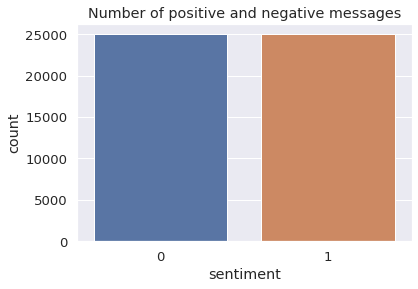

In [31]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.sentiment).set_title("Number of positive and negative messages")
plt.show()

**Sentiment Distribution**

Now we check the percentage of Postive and Negative Sentiment:

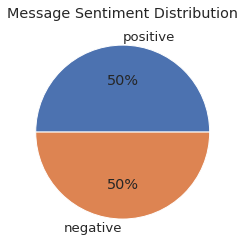

In [32]:
sms = pd.value_counts(df["sentiment"], sort=True)
sms.plot(kind="pie", labels=["positive", "negative"], autopct="%1.0f%%")

plt.title("Message Sentiment Distribution")
plt.ylabel("")
plt.show()

Above 50% of these messages messages arepositive and 50% of them are negative.


Length of text messages:

In [33]:
df['length'] = df.review.apply(len)
df.head()

,review,sentiment,length
0,One of the other reviewers has mentioned that ...,1,1761
1,A wonderful little production. <br /><br />The...,1,998
2,I thought this was a wonderful way to spend ti...,1,926
3,Basically there's a family where a little boy ...,0,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317


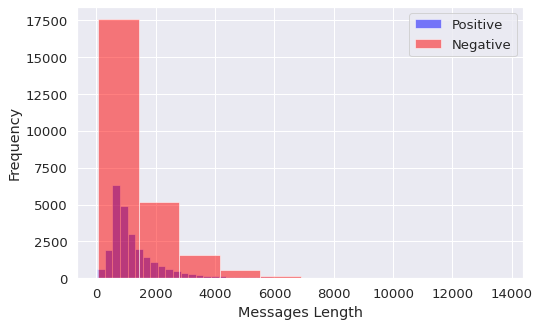

In [34]:
plt.figure(figsize=(8, 5))
df[df.sentiment == 0].length.plot(bins=35, kind='hist', color='blue', label='Positive', alpha=0.5)
df[df.sentiment == 1].length.plot(kind='hist', color='red', label='Negative', alpha=0.5)
plt.legend()
plt.xlabel("Messages Length");

Now let's see if the length has an influence on sentiment:

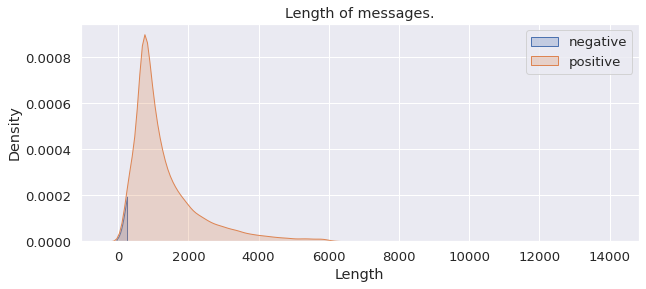

In [35]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df.loc[df.sentiment == 0, "length"], shade=True, label="negative", clip=(-50, 250),)
sns.kdeplot(df.loc[df.sentiment == 1, "length"], shade=True, label="positive")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of messages.",
)
ax.legend(loc="upper right")
plt.show()

As we can notice the positve messages are longer than negative ones (that is normal due to the number of words) and  have around 2000 characters.

### **Text Pre-processing**

In the next step we clean text, remove stop words and apply stemming operation for each line of text:


In [36]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [37]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [38]:
df['review'] = df['review'].apply(clean_text)
df['review'] = df['review'].apply(remove_stopwords)
df['review'] = df['review'].apply(stemmer)

In [39]:
df.head()

,review,sentiment,length
0,one review mention watch oz episod hook right ...,1,1761
1,wonder littl product br br film techniqu unass...,1,998
2,thought wonder way spend time hot summer weeke...,1,926
3,basic famili littl boy jake think zombi closet...,0,748
4,petter mattei love time money visual stun film...,1,1317


In [40]:
print(df['review'].apply(lambda x: len(x.split(' '))).sum())

6109604


### **BERT model**

BERT (Bidirectional Encoder Representations from Transformers) is a pretrained NLP algorithm devolped by google AI. BERT is a bidirectionally trained of Transformer a popular attention model, use to language modelling. So it can have a deeper sense of language context and flow compared to the single-direction language models. BERT model instead of predicting the next word in a sequence makes use of a novel technique called Masked LM (MLM). It relies on randomly masks words in the sentence and then it tries to predict them. Unlike the previous language models, it takes both the previous and next tokens into account at the same time. This is a contrast to previous LSTM based models combined a text sequence left-to-right and right-to-left.

In the first step we have to make tokenization on our dataset. Tokenization will allow us to feed batches of sequences into the model at the same time. 

To do the tokenization of our datasets we have to choose  a pre-trained model. We load the basic model (`bert-large-uncased`) from the Huggingface Transformers library.

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
tokenizer

PreTrainedTokenizer(name_or_path='bert-large-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Now we have to load BERT model. In the Transformers library is avaliable many different BERT models. We use the „TFBertModel”  model (bert-base-uncased) from the library.

In [42]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Spliting the data into train and test sets:

In [43]:
X = df['review']
Y = df['sentiment'] 

In [44]:
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

The function which allows to encode our dataset with BERT tokenizer. We have decided on a maximum sentence length is 64 (maxlen).


In [45]:
def encode(text, maxlen):
  input_ids=[]
  attention_masks=[]

  for row in text:
    encoded = tokenizer.encode_plus(
        row,
        add_special_tokens=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)


Based on this  encodings for our training and testing datasets are generated as follows:

In [46]:
X_train_input_ids, X_train_attention_masks = encode(X_train.values, maxlen=68)
X_test_input_ids, X_test_attention_masks = encode(X_test.values, maxlen=68)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### **Build the model**

We create a model using BERT model and then add two Dense layers with Dropout layer.

In [47]:
def build_model(bert_model):
   input_word_ids = tf.keras.Input(shape=(68,),dtype='int32')
   attention_masks = tf.keras.Input(shape=(68,),dtype='int32')

   sequence_output = bert_model([input_word_ids,attention_masks])
   output = sequence_output[1]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

   model = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
   model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

   return model

In [48]:
model = build_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 68)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 68)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 68,                                            

We set class weights for the loss function to adjust for class imbalance. 'Spam' variable is set to weight 8x more.

We train the model for 5 epoch:

In [49]:
class_weight = {0: 1, 1: 8}

In [50]:
history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    Y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_test_input_ids, X_test_attention_masks], Y_test))

Epoch 1/10
1250/1250 [==============================] - 605s 476ms/step - loss: 0.4718 - accuracy: 0.7710 - val_loss: 0.4089 - val_accuracy: 0.8109
Epoch 2/10
1250/1250 [==============================] - 592s 474ms/step - loss: 0.3591 - accuracy: 0.8419 - val_loss: 0.3788 - val_accuracy: 0.8310
Epoch 3/10
1250/1250 [==============================] - 592s 474ms/step - loss: 0.2859 - accuracy: 0.8806 - val_loss: 0.4033 - val_accuracy: 0.8316
Epoch 4/10
1250/1250 [==============================] - 592s 474ms/step - loss: 0.2078 - accuracy: 0.9177 - val_loss: 0.4713 - val_accuracy: 0.8293
Epoch 5/10
1250/1250 [==============================] - 592s 474ms/step - loss: 0.1435 - accuracy: 0.9452 - val_loss: 0.5433 - val_accuracy: 0.8295
Epoch 6/10
1250/1250 [==============================] - 592s 473ms/step - loss: 0.1008 - accuracy: 0.9640 - val_loss: 0.6196 - val_accuracy: 0.8273
Epoch 7/10
1250/1250 [==============================] - 592s 473ms/step - loss: 0.0731 - accuracy: 0.9748 - val_

Visualization of training:

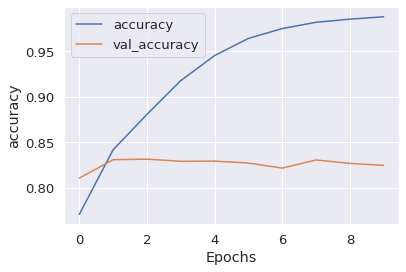

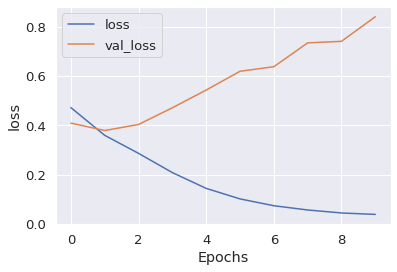

In [51]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Predictions on a test set:

In [52]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_masks], Y_test)
print('Test accuracy :', accuracy)

313/313 [==============================] - 49s 157ms/step - loss: 0.8412 - accuracy: 0.8248
Test accuracy : 0.8248000144958496


In [53]:
#save model
model.save_weights('bert_model')

### **Summary**

For our analysis we used a pretrained BERT model to resolve our classification problem.  After trained model we achieved an accuracy on the test set equal to 98 % and it is a very good result in comparison to previous Machine Learning models that we have used (e.g. Logistic Regression).
